# Midterm Regression Pipeline - Song Release Year Prediction

## Objective
To design and implement an end-to-end regression pipeline that can predict the release year of a song from audio features.

## Dataset
- **Million Song Dataset (MSD)** subset
- **515,344 samples**, **90 features** (1 target + 12 timbre averages + 78 timbre covariances)
- **Target**: Release year of the song (continuous value)

## Workflow
1. Data Loading & Exploration
2. Data Preprocessing & Cleaning
3. Feature Engineering & Selection
4. Model Training (ML & DL)
5. Hyperparameter Tuning
6. Evaluation & Interpretation

## 1. Import Libraries & Setup

In [87]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Data Loading & Exploration

In [88]:
# Load dataset
# Note: This dataset has no header. First column is target (year), rest are audio features
file_path = 'midterm-regresi-dataset.csv'

# Create column names
# Column 0: Target (Year)
# Columns 1-12: Timbre average values
# Columns 13-90: Timbre covariance values (upper triangular of 12x12 matrix = 78 values)
column_names = ['year'] + [f'timbre_avg_{i}' for i in range(1, 13)] + [f'timbre_cov_{i}' for i in range(1, 79)]

df = pd.read_csv(file_path, header=None, names=column_names)

print(f"Dataset Shape: {df.shape}")
print(f"Number of samples: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1] - 1}")  # Excluding target
df.head(10)

Dataset Shape: (515345, 91)
Number of samples: 515,345
Number of features: 90


,year,timbre_avg_1,timbre_avg_2,timbre_avg_3,timbre_avg_4,timbre_avg_5,timbre_avg_6,timbre_avg_7,timbre_avg_8,timbre_avg_9,timbre_avg_10,timbre_avg_11,timbre_avg_12,timbre_cov_1,timbre_cov_2,timbre_cov_3,timbre_cov_4,timbre_cov_5,timbre_cov_6,timbre_cov_7,timbre_cov_8,timbre_cov_9,timbre_cov_10,timbre_cov_11,timbre_cov_12,timbre_cov_13,timbre_cov_14,timbre_cov_15,timbre_cov_16,timbre_cov_17,timbre_cov_18,timbre_cov_19,timbre_cov_20,timbre_cov_21,timbre_cov_22,timbre_cov_23,timbre_cov_24,timbre_cov_25,timbre_cov_26,timbre_cov_27,timbre_cov_28,timbre_cov_29,timbre_cov_30,timbre_cov_31,timbre_cov_32,timbre_cov_33,timbre_cov_34,timbre_cov_35,timbre_cov_36,timbre_cov_37,timbre_cov_38,timbre_cov_39,timbre_cov_40,timbre_cov_41,timbre_cov_42,timbre_cov_43,timbre_cov_44,timbre_cov_45,timbre_cov_46,timbre_cov_47,timbre_cov_48,timbre_cov_49,timbre_cov_50,timbre_cov_51,timbre_cov_52,timbre_cov_53,timbre_cov_54,timbre_cov_55,timbre_cov_56,timbre_cov_57,timbre_cov_58,timbre_cov_59,timbre_cov_60,timbre_cov_61,timbre_cov_62,timbre_cov_63,timbre_cov_64,timbre_cov_65,timbre_cov_66,timbre_cov_67,timbre_cov_68,timbre_cov_69,timbre_cov_70,timbre_cov_71,timbre_cov_72,timbre_cov_73,timbre_cov_74,timbre_cov_75,timbre_cov_76,timbre_cov_77,timbre_cov_78
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,73.04667,-37.36684,-3.13853,-24.21531,-13.23066,15.93809,-18.60478,82.15479,240.57980,-10.29407,31.58431,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,202.18689,-33.44277,195.04749,-16.93235,-1.09168,-25.38061,-12.19034,-125.94783,121.74212,136.67075,41.18157,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,13.09302,5.89085,6.89034,-10.97160,1.67565,11.43523,-7.27994,133.08169,141.86758,-56.99356,98.15952,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662

In [89]:
# Basic Dataset Info
print("="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"📈 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n📋 Data Types:")
print(df.dtypes.value_counts())

print("\n" + "="*60)
print("BASIC STATISTICS")
print("="*60)
df.describe().T

DATASET INFORMATION

📊 Dataset Shape: (515345, 91)
📈 Memory Usage: 357.79 MB

📋 Data Types:
float64    90
int64       1
Name: count, dtype: int64

BASIC STATISTICS


,count,mean,std,min,25%,50%,75%,max
year,515345.0,1998.397082,10.931046,1922.00000,1994.00000,2002.00000,2006.00000,2011.00000
timbre_avg_1,515345.0,43.387126,6.067558,1.74900,39.95469,44.25850,47.83389,61.97014
timbre_avg_2,515345.0,1.289554,51.580351,-337.09250,-26.05952,8.41785,36.12401,384.06573
timbre_avg_3,515345.0,8.658347,35.268585,-301.00506,-11.46271,10.47632,29.76482,322.85143
timbre_avg_4,515345.0,1.164124,16.322790,-154.18358,-8.48750,-0.65284,8.78754,335.77182
...,...,...,...,...,...,...,...,...
timbre_cov_74,515345.0,17.669213,114.427905,-3168.92457,-31.58061,15.59847,67.79496,3662.06565
timbre_cov_75,515345.0,-26.315336,173.977336,-4319.99232,-101.53030,-21.20412,52.38933,2833.60895
timbre_cov_76,515345.0,4.458641,13.346557,-236.03926,-2.56609,3.11764,9.96774,463.41950
timbre_cov_77,515345.0,20.035136,185.558247,-7458.37815,-59.50927,7.75973,86.35161,7393.39844


In [90]:
# Check for missing values
print("="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage (%)': missing_percentage
})

if missing_values.sum() == 0:
    print("✅ No missing values found in the dataset!")
else:
    print(f"⚠️ Total missing values: {missing_values.sum()}")
    print(missing_df[missing_df['Missing Count'] > 0])

MISSING VALUES ANALYSIS
✅ No missing values found in the dataset!


TARGET VARIABLE (YEAR) ANALYSIS


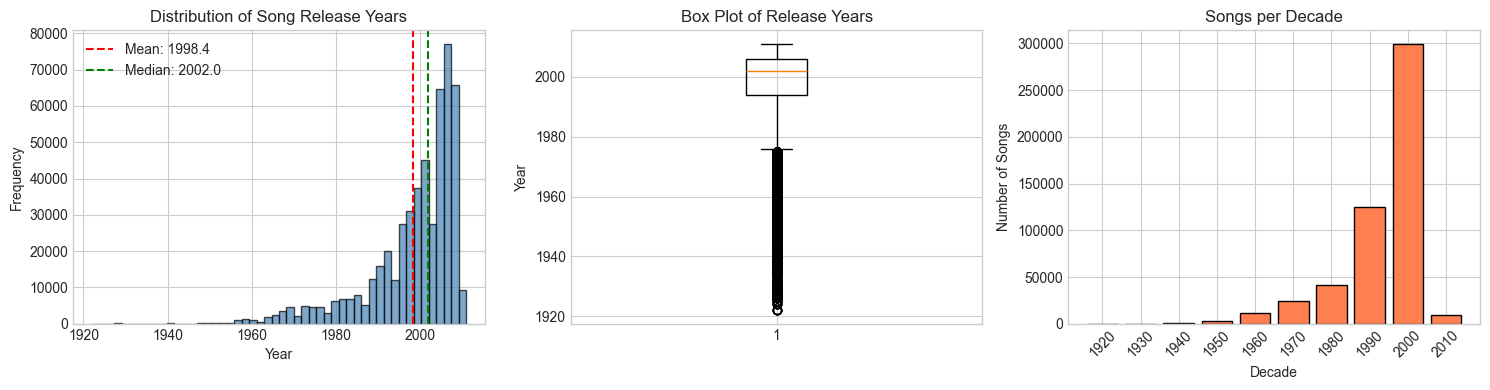


📅 Year Range: 1922 - 2011
📊 Mean Year: 1998.40
📊 Median Year: 2002.00
📊 Std Dev: 10.93


In [91]:
# Target Variable Analysis
print("="*60)
print("TARGET VARIABLE (YEAR) ANALYSIS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution of years
axes[0].hist(df['year'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Song Release Years')
axes[0].axvline(df['year'].mean(), color='red', linestyle='--', label=f'Mean: {df["year"].mean():.1f}')
axes[0].axvline(df['year'].median(), color='green', linestyle='--', label=f'Median: {df["year"].median():.1f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['year'], vert=True)
axes[1].set_ylabel('Year')
axes[1].set_title('Box Plot of Release Years')

# Year counts per decade
df['decade'] = (df['year'] // 10) * 10
decade_counts = df['decade'].value_counts().sort_index()
axes[2].bar(decade_counts.index.astype(str), decade_counts.values, color='coral', edgecolor='black')
axes[2].set_xlabel('Decade')
axes[2].set_ylabel('Number of Songs')
axes[2].set_title('Songs per Decade')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Drop the decade column (only used for visualization)
df.drop('decade', axis=1, inplace=True)

print(f"\n📅 Year Range: {df['year'].min()} - {df['year'].max()}")
print(f"📊 Mean Year: {df['year'].mean():.2f}")
print(f"📊 Median Year: {df['year'].median():.2f}")
print(f"📊 Std Dev: {df['year'].std():.2f}")

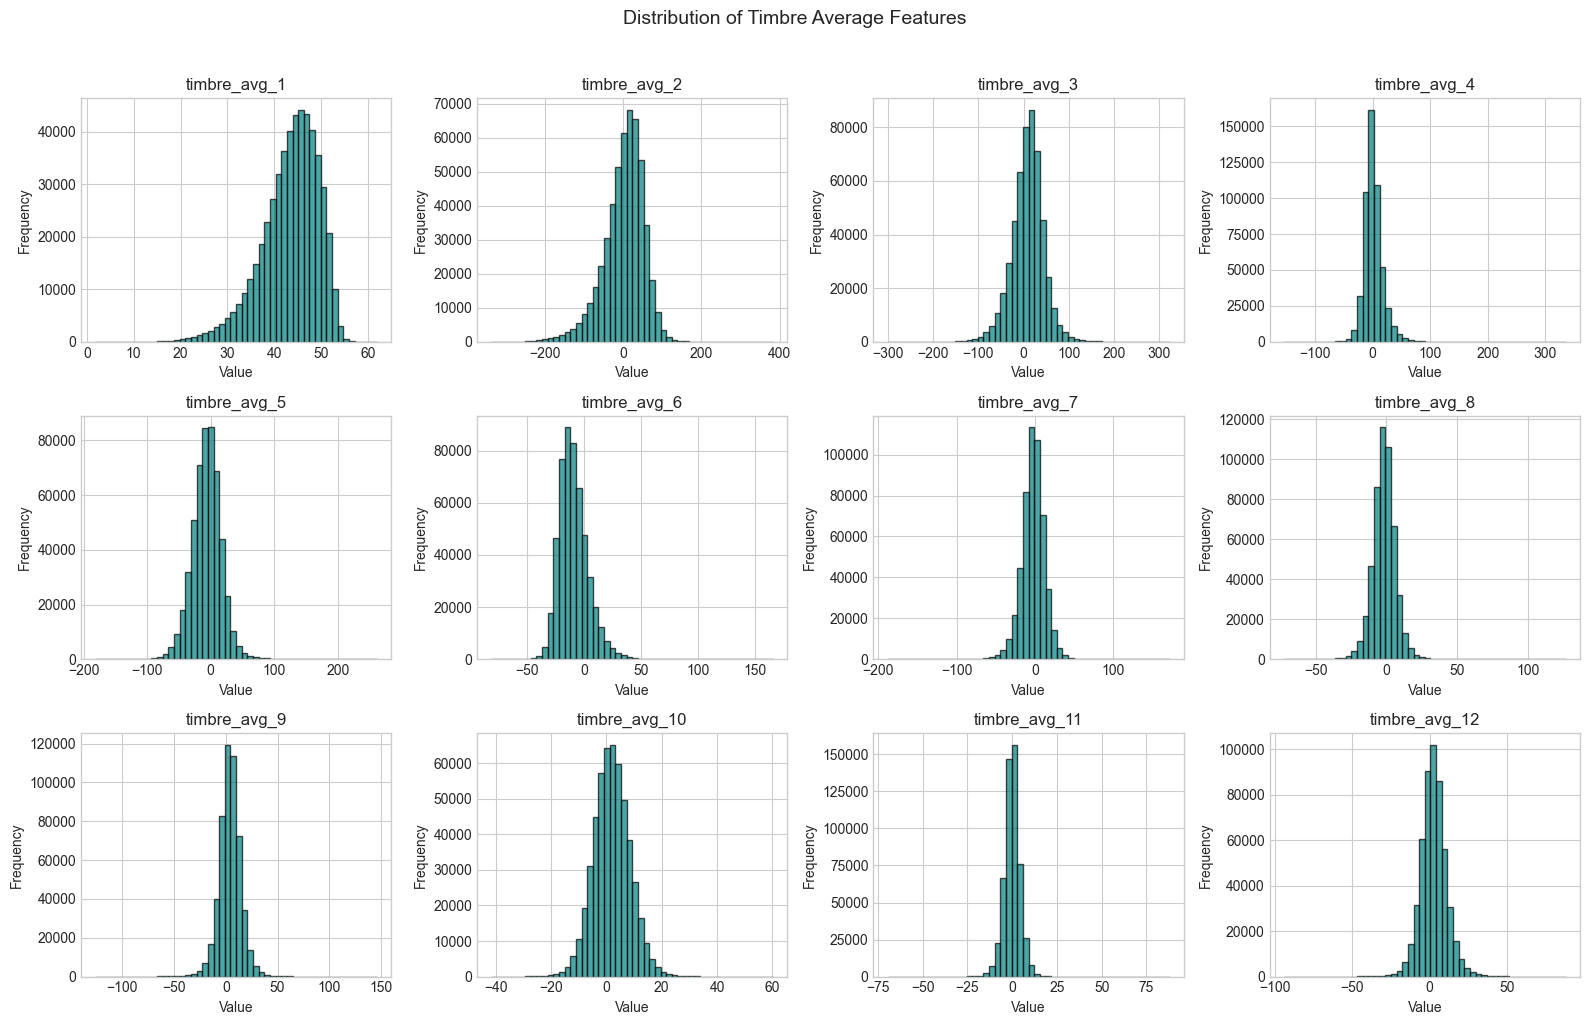

In [92]:
# Feature Distribution Analysis (Sample of timbre averages)
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

timbre_avg_cols = [col for col in df.columns if 'timbre_avg' in col]

for i, col in enumerate(timbre_avg_cols):
    axes[i].hist(df[col], bins=50, edgecolor='black', alpha=0.7, color='teal')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Timbre Average Features', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing & Cleaning

In [93]:
# Check for duplicates
print("="*60)
print("DUPLICATE ANALYSIS")
print("="*60)

duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates:,}")

if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df = df.drop_duplicates()
    print(f"New dataset shape: {df.shape}")
else:
    print("✅ No duplicate rows found!")

DUPLICATE ANALYSIS
Number of duplicate rows: 214
Removing 214 duplicate rows...
New dataset shape: (515131, 91)


In [94]:
# Outlier Detection and Handling using IQR method
print("="*60)
print("OUTLIER ANALYSIS & HANDLING")
print("="*60)

def detect_outliers_iqr(df, columns, threshold=1.5):
    """Detect outliers using IQR method"""
    outlier_indices = []
    outlier_counts = {}
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_counts[col] = outlier_mask.sum()
        outlier_indices.extend(df[outlier_mask].index.tolist())
    
    return list(set(outlier_indices)), outlier_counts

# Detect outliers in feature columns (not target)
feature_cols = [col for col in df.columns if col != 'year']
outlier_indices, outlier_counts = detect_outliers_iqr(df, feature_cols)

print(f"Total rows with outliers: {len(outlier_indices):,} ({len(outlier_indices)/len(df)*100:.2f}%)")
print(f"\nTop 10 features with most outliers:")
sorted_outliers = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for feat, count in sorted_outliers:
    print(f"  {feat}: {count:,} outliers ({count/len(df)*100:.2f}%)")

OUTLIER ANALYSIS & HANDLING
Total rows with outliers: 325,323 (63.15%)

Top 10 features with most outliers:
  timbre_cov_56: 46,737 outliers (9.07%)
  timbre_cov_25: 46,174 outliers (8.96%)
  timbre_cov_15: 45,578 outliers (8.85%)
  timbre_cov_34: 42,437 outliers (8.24%)
  timbre_cov_13: 41,976 outliers (8.15%)
  timbre_cov_14: 40,179 outliers (7.80%)
  timbre_cov_65: 39,704 outliers (7.71%)
  timbre_cov_78: 39,458 outliers (7.66%)
  timbre_cov_58: 39,269 outliers (7.62%)
  timbre_cov_77: 39,134 outliers (7.60%)


In [95]:
# Handle outliers using clipping (winsorization) instead of removal
# This preserves data while limiting extreme values
print("\n🔧 Handling outliers using clipping (winsorization)...")

df_cleaned = df.copy()

for col in feature_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)

print("✅ Outliers handled successfully!")
print(f"Dataset shape after cleaning: {df_cleaned.shape}")


🔧 Handling outliers using clipping (winsorization)...
✅ Outliers handled successfully!
Dataset shape after cleaning: (515131, 91)


In [96]:
# Separate Features and Target
X = df_cleaned.drop('year', axis=1)
y = df_cleaned['year']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns[:5])} ... {list(X.columns[-5:])}")

Features shape: (515131, 90)
Target shape: (515131,)

Feature columns: ['timbre_avg_1', 'timbre_avg_2', 'timbre_avg_3', 'timbre_avg_4', 'timbre_avg_5'] ... ['timbre_cov_74', 'timbre_cov_75', 'timbre_cov_76', 'timbre_cov_77', 'timbre_cov_78']


In [97]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"Training set size: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining target - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Test target - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

TRAIN-TEST SPLIT
Training set size: 412,104 samples (80.0%)
Test set size: 103,027 samples (20.0%)

Training target - Mean: 1998.39, Std: 10.95
Test target - Mean: 1998.44, Std: 10.85


In [98]:
# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Feature scaling completed using StandardScaler")
print(f"\nScaled training features - Mean: {X_train_scaled.mean().mean():.6f}, Std: {X_train_scaled.std().mean():.6f}")

✅ Feature scaling completed using StandardScaler

Scaled training features - Mean: -0.000000, Std: 1.000001


## 4. Feature Engineering & Selection

CORRELATION ANALYSIS
Top 15 features most correlated with Year:
timbre_avg_1     0.232332
timbre_avg_6    -0.192311
timbre_avg_3    -0.143083
timbre_cov_51   -0.142355
timbre_cov_28   -0.136652
timbre_cov_45   -0.116595
timbre_cov_34   -0.115834
timbre_cov_57   -0.115020
timbre_cov_24   -0.113424
timbre_cov_35    0.113330
timbre_avg_7     0.111766
timbre_cov_55   -0.108940
timbre_cov_47   -0.105144
timbre_cov_21   -0.104820
timbre_avg_12   -0.099500
Name: year, dtype: float64


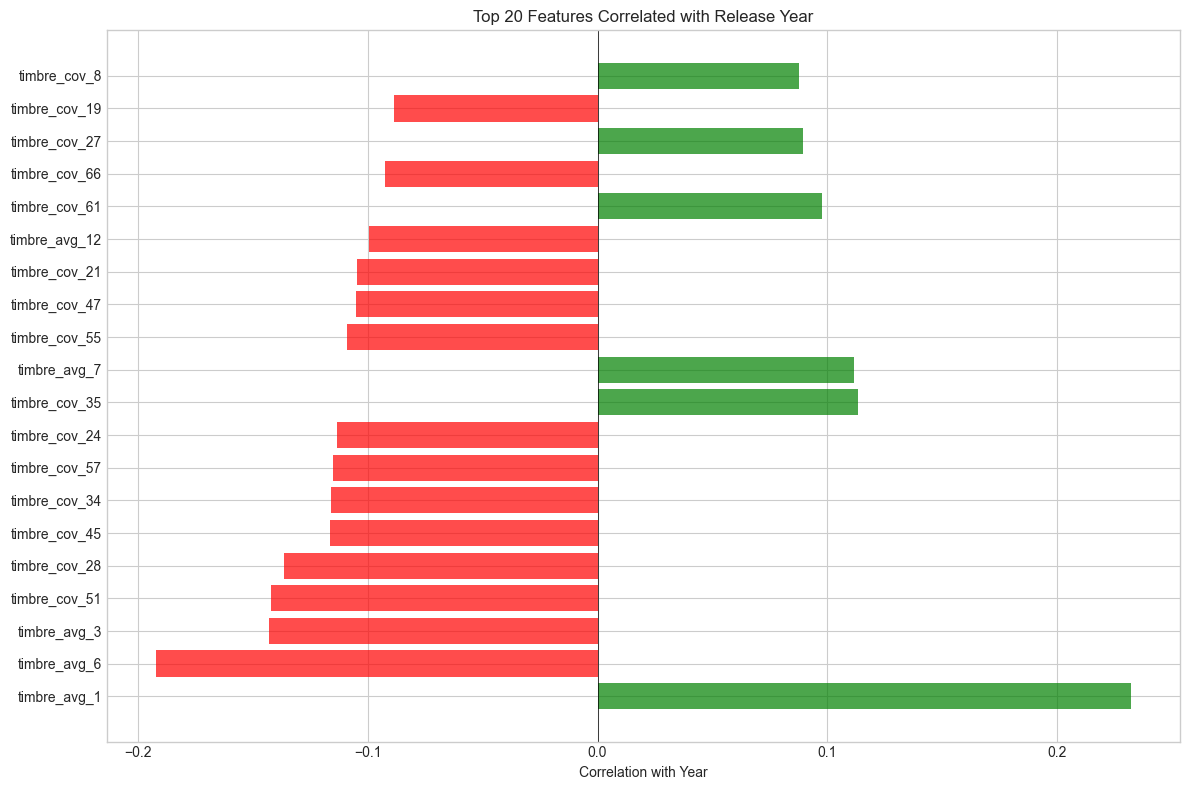

In [99]:
# Correlation Analysis with Target
print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Calculate correlation with target
correlations = df_cleaned.corr()['year'].drop('year').sort_values(key=abs, ascending=False)

print("Top 15 features most correlated with Year:")
print(correlations.head(15))

# Visualize top correlations
fig, ax = plt.subplots(figsize=(12, 8))
top_20_corr = correlations.head(20)
colors = ['green' if x > 0 else 'red' for x in top_20_corr.values]
ax.barh(range(len(top_20_corr)), top_20_corr.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_20_corr)))
ax.set_yticklabels(top_20_corr.index)
ax.set_xlabel('Correlation with Year')
ax.set_title('Top 20 Features Correlated with Release Year')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [100]:
# Feature Selection using SelectKBest with f_regression
print("="*60)
print("FEATURE SELECTION - SelectKBest (f_regression)")
print("="*60)

# Select top 30 features
k_features = 30
selector = SelectKBest(score_func=f_regression, k=k_features)
selector.fit(X_train_scaled, y_train)

# Get selected feature names
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': selector.scores_,
    'P-Value': selector.pvalues_
}).sort_values('F-Score', ascending=False)

print(f"\nTop {k_features} Selected Features:")
print(feature_scores.head(k_features))

# Get selected features
selected_features = feature_scores.head(k_features)['Feature'].tolist()

# Transform data with selected features
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"\n✅ Feature selection completed: {X_train.shape[1]} → {len(selected_features)} features")

FEATURE SELECTION - SelectKBest (f_regression)

Top 30 Selected Features:
          Feature       F-Score  P-Value
0    timbre_avg_1  23651.909606      0.0
5    timbre_avg_6  15885.628852      0.0
2    timbre_avg_3   8716.332481      0.0
62  timbre_cov_51   8653.514597      0.0
39  timbre_cov_28   7836.156433      0.0
56  timbre_cov_45   5685.967769      0.0
45  timbre_cov_34   5640.593993      0.0
68  timbre_cov_57   5585.038720      0.0
35  timbre_cov_24   5488.166145      0.0
46  timbre_cov_35   5387.085424      0.0
6    timbre_avg_7   5350.569489      0.0
66  timbre_cov_55   5037.119097      0.0
58  timbre_cov_47   4651.284978      0.0
32  timbre_cov_21   4609.628463      0.0
11  timbre_avg_12   4121.436707      0.0
72  timbre_cov_61   4027.871699      0.0
77  timbre_cov_66   3555.156548      0.0
38  timbre_cov_27   3307.344921      0.0
73  timbre_cov_62   3238.861337      0.0
30  timbre_cov_19   3189.193774      0.0
19   timbre_cov_8   3148.011230      0.0
67  timbre_cov_56   2909

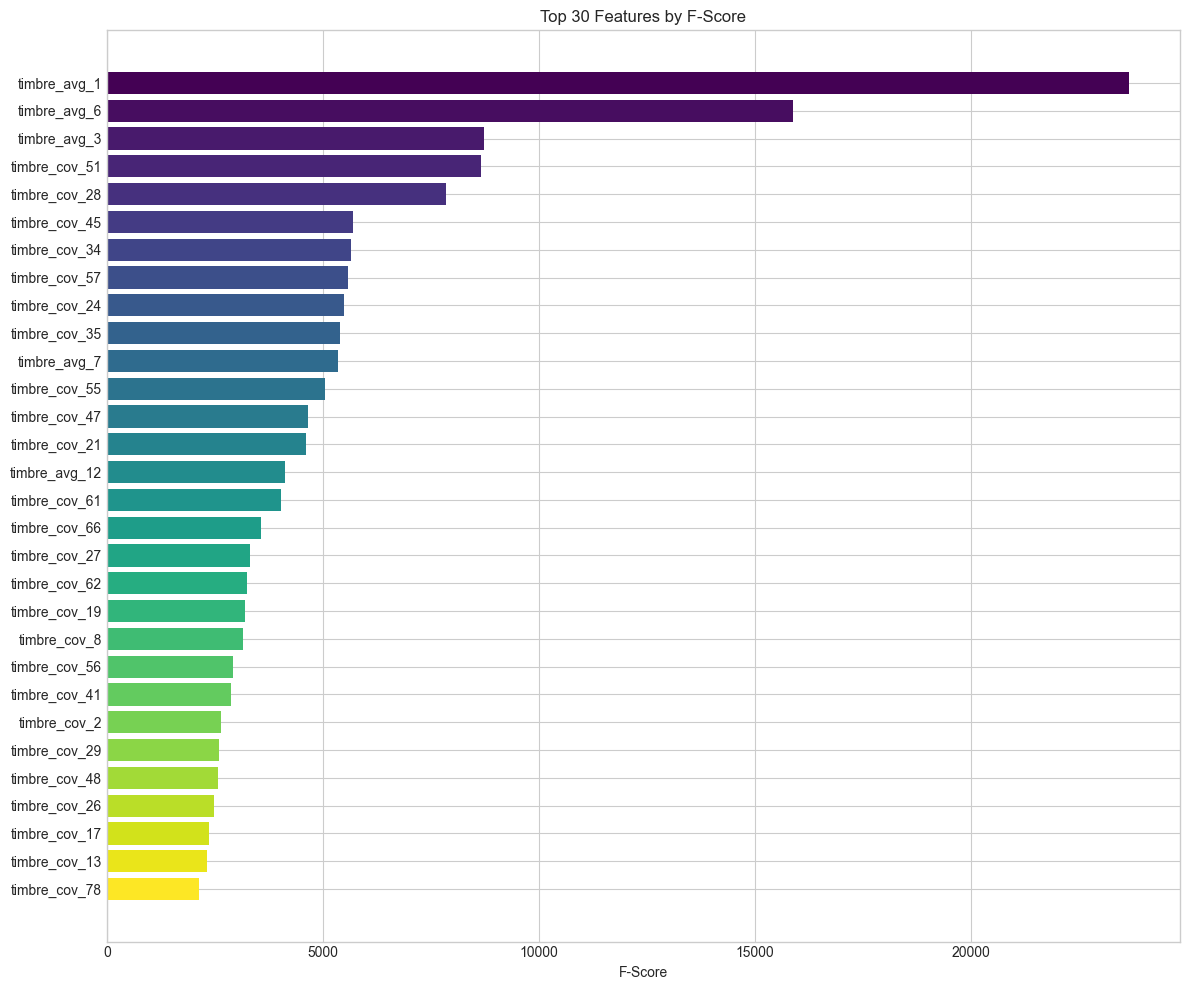

In [101]:
# Visualize Feature Importance Scores
fig, ax = plt.subplots(figsize=(12, 10))
top_30 = feature_scores.head(30)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_30)))
ax.barh(range(len(top_30)), top_30['F-Score'].values, color=colors)
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels(top_30['Feature'].values)
ax.set_xlabel('F-Score')
ax.set_title('Top 30 Features by F-Score')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Model Training - Machine Learning Models

In [102]:
# Helper function for model evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a regression model"""
    from time import time
    
    # Training
    start_time = time()
    model.fit(X_train, y_train)
    train_time = time() - start_time
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Training Time (s)': train_time
    }
    
    return metrics, y_test_pred

# Store results
results = []
predictions = {}

print("✅ Evaluation function created!")

✅ Evaluation function created!


### 5.1 Linear Regression (Baseline)

In [103]:
# 1. Linear Regression (Baseline)
print("="*60)
print("LINEAR REGRESSION (BASELINE)")
print("="*60)

lr_model = LinearRegression()
lr_metrics, lr_preds = evaluate_model(
    lr_model, X_train_selected, X_test_selected, y_train, y_test, 'Linear Regression'
)
results.append(lr_metrics)
predictions['Linear Regression'] = lr_preds

print(f"Train RMSE: {lr_metrics['Train RMSE']:.4f}")
print(f"Test RMSE: {lr_metrics['Test RMSE']:.4f}")
print(f"Train R²: {lr_metrics['Train R²']:.4f}")
print(f"Test R²: {lr_metrics['Test R²']:.4f}")
print(f"Training Time: {lr_metrics['Training Time (s)']:.4f}s")

LINEAR REGRESSION (BASELINE)
Train RMSE: 9.8506
Test RMSE: 9.7826
Train R²: 0.1911
Test R²: 0.1868
Training Time: 0.3392s


### 5.2 Ridge Regression (L2 Regularization)

In [104]:
# 2. Ridge Regression
print("="*60)
print("RIDGE REGRESSION")
print("="*60)

ridge_model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_metrics, ridge_preds = evaluate_model(
    ridge_model, X_train_selected, X_test_selected, y_train, y_test, 'Ridge Regression'
)
results.append(ridge_metrics)
predictions['Ridge Regression'] = ridge_preds

print(f"Train RMSE: {ridge_metrics['Train RMSE']:.4f}")
print(f"Test RMSE: {ridge_metrics['Test RMSE']:.4f}")
print(f"Train R²: {ridge_metrics['Train R²']:.4f}")
print(f"Test R²: {ridge_metrics['Test R²']:.4f}")
print(f"Training Time: {ridge_metrics['Training Time (s)']:.4f}s")

RIDGE REGRESSION
Train RMSE: 9.8506
Test RMSE: 9.7826
Train R²: 0.1911
Test R²: 0.1868
Training Time: 0.0909s


### 5.3 Lasso Regression (L1 Regularization)

In [105]:
# 3. Lasso Regression
print("="*60)
print("LASSO REGRESSION")
print("="*60)

lasso_model = Lasso(alpha=0.1, random_state=RANDOM_STATE)
lasso_metrics, lasso_preds = evaluate_model(
    lasso_model, X_train_selected, X_test_selected, y_train, y_test, 'Lasso Regression'
)
results.append(lasso_metrics)
predictions['Lasso Regression'] = lasso_preds

print(f"Train RMSE: {lasso_metrics['Train RMSE']:.4f}")
print(f"Test RMSE: {lasso_metrics['Test RMSE']:.4f}")
print(f"Train R²: {lasso_metrics['Train R²']:.4f}")
print(f"Test R²: {lasso_metrics['Test R²']:.4f}")
print(f"Training Time: {lasso_metrics['Training Time (s)']:.4f}s")

LASSO REGRESSION
Train RMSE: 9.8671
Test RMSE: 9.7943
Train R²: 0.1884
Test R²: 0.1849
Training Time: 0.2239s


### 5.4 ElasticNet (L1 + L2 Regularization)

In [106]:
# 4. ElasticNet
print("="*60)
print("ELASTICNET REGRESSION")
print("="*60)

elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE)
elastic_metrics, elastic_preds = evaluate_model(
    elastic_model, X_train_selected, X_test_selected, y_train, y_test, 'ElasticNet'
)
results.append(elastic_metrics)
predictions['ElasticNet'] = elastic_preds

print(f"Train RMSE: {elastic_metrics['Train RMSE']:.4f}")
print(f"Test RMSE: {elastic_metrics['Test RMSE']:.4f}")
print(f"Train R²: {elastic_metrics['Train R²']:.4f}")
print(f"Test R²: {elastic_metrics['Test R²']:.4f}")
print(f"Training Time: {elastic_metrics['Training Time (s)']:.4f}s")

ELASTICNET REGRESSION
Train RMSE: 9.8669
Test RMSE: 9.7945
Train R²: 0.1884
Test R²: 0.1848
Training Time: 0.2280s


### 5.5 Decision Tree Regressor

In [107]:
# 5. Decision Tree Regressor
print("="*60)
print("DECISION TREE REGRESSOR")
print("="*60)

dt_model = DecisionTreeRegressor(max_depth=15, min_samples_split=10, random_state=RANDOM_STATE)
dt_metrics, dt_preds = evaluate_model(
    dt_model, X_train_selected, X_test_selected, y_train, y_test, 'Decision Tree'
)
results.append(dt_metrics)
predictions['Decision Tree'] = dt_preds

print(f"Train RMSE: {dt_metrics['Train RMSE']:.4f}")
print(f"Test RMSE: {dt_metrics['Test RMSE']:.4f}")
print(f"Train R²: {dt_metrics['Train R²']:.4f}")
print(f"Test R²: {dt_metrics['Test R²']:.4f}")
print(f"Training Time: {dt_metrics['Training Time (s)']:.4f}s")

DECISION TREE REGRESSOR
Train RMSE: 8.2300
Test RMSE: 10.6635
Train R²: 0.4353
Test R²: 0.0338
Training Time: 20.4639s


### 5.6 Random Forest Regressor

In [108]:
# 6. Random Forest Regressor
print("="*60)
print("RANDOM FOREST REGRESSOR")
print("="*60)

rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=15, 
    min_samples_split=10,
    n_jobs=-1, 
    random_state=RANDOM_STATE
)
rf_metrics, rf_preds = evaluate_model(
    rf_model, X_train_selected, X_test_selected, y_train, y_test, 'Random Forest'
)
results.append(rf_metrics)
predictions['Random Forest'] = rf_preds

print(f"Train RMSE: {rf_metrics['Train RMSE']:.4f}")
print(f"Test RMSE: {rf_metrics['Test RMSE']:.4f}")
print(f"Train R²: {rf_metrics['Train R²']:.4f}")
print(f"Test R²: {rf_metrics['Test R²']:.4f}")
print(f"Training Time: {rf_metrics['Training Time (s)']:.4f}s")

RANDOM FOREST REGRESSOR
Train RMSE: 7.7510
Test RMSE: 9.3365
Train R²: 0.4992
Test R²: 0.2593
Training Time: 202.5517s


### 5.7 Gradient Boosting Regressor

In [109]:
# 7. Gradient Boosting Regressor
print("="*60)
print("GRADIENT BOOSTING REGRESSOR")
print("="*60)

# Use a sample for faster training (Gradient Boosting is slow on large datasets)
sample_size = 50000
sample_indices = np.random.choice(len(X_train_selected), size=sample_size, replace=False)
X_train_sample = X_train_selected.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)
gb_metrics, gb_preds = evaluate_model(
    gb_model, X_train_sample, X_test_selected, y_train_sample, y_test, 'Gradient Boosting'
)
results.append(gb_metrics)
predictions['Gradient Boosting'] = gb_preds

print(f"(Trained on {sample_size:,} samples for efficiency)")
print(f"Train RMSE: {gb_metrics['Train RMSE']:.4f}")
print(f"Test RMSE: {gb_metrics['Test RMSE']:.4f}")
print(f"Train R²: {gb_metrics['Train R²']:.4f}")
print(f"Test R²: {gb_metrics['Test R²']:.4f}")
print(f"Training Time: {gb_metrics['Training Time (s)']:.4f}s")

GRADIENT BOOSTING REGRESSOR
(Trained on 50,000 samples for efficiency)
Train RMSE: 8.8171
Test RMSE: 9.3912
Train R²: 0.3510
Test R²: 0.2506
Training Time: 90.7737s


## 6. Deep Learning Model (Neural Network)

In [110]:
# Import PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print("✅ Deep Learning libraries imported!")

PyTorch version: 2.9.0+cu130
Device: cuda
✅ Deep Learning libraries imported!


In [111]:
# Build Neural Network Model with PyTorch
print("="*60)
print("NEURAL NETWORK (DEEP LEARNING - PyTorch)")
print("="*60)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        
        self.network = nn.Sequential(
            # Input Layer
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            # Hidden Layer 1
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            # Hidden Layer 2
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            # Hidden Layer 3
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            
            # Output Layer
            nn.Linear(32, 1)  # Linear output for regression
        )
    
    def forward(self, x):
        return self.network(x)

# Build model
input_dim = X_train_selected.shape[1]
nn_model = NeuralNetwork(input_dim).to(device)

# Print model summary
print(f"\nModel Architecture:")
print(nn_model)
total_params = sum(p.numel() for p in nn_model.parameters())
trainable_params = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

NEURAL NETWORK (DEEP LEARNING - PyTorch)

Model Architecture:
NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=32, out_features=1, bias=True)
  )
)

Tot

In [112]:
# Train Neural Network with PyTorch
from time import time

# Prepare data for PyTorch
X_train_tensor = torch.FloatTensor(X_train_selected.values).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test_selected.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)

# Create validation split
val_size = int(0.2 * len(X_train_tensor))
train_size = len(X_train_tensor) - val_size

indices = torch.randperm(len(X_train_tensor))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

X_train_nn = X_train_tensor[train_indices]
y_train_nn = y_train_tensor[train_indices]
X_val_nn = X_train_tensor[val_indices]
y_val_nn = y_train_tensor[val_indices]

# Create DataLoaders
batch_size = 256
train_dataset = TensorDataset(X_train_nn, y_train_nn)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

# Training parameters
epochs = 100
patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
last_lr = optimizer.param_groups[0]['lr']

# History tracking
history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}

print("Training Neural Network...")
start_time = time()

for epoch in range(epochs):
    # Training phase
    nn_model.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        train_mae += torch.mean(torch.abs(outputs - batch_y)).item() * batch_X.size(0)
    
    train_loss /= len(train_dataset)
    train_mae /= len(train_dataset)
    
    # Validation phase
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_nn)
        val_loss = criterion(val_outputs, y_val_nn).item()
        val_mae = torch.mean(torch.abs(val_outputs - y_val_nn)).item()
    
    # Record history
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Check if learning rate changed
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != last_lr:
        print(f"Epoch {epoch+1}: Learning rate reduced from {last_lr:.6f} to {current_lr:.6f}")
        last_lr = current_lr
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = nn_model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - MAE: {train_mae:.4f} - Val MAE: {val_mae:.4f}")
    
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Restore best model
if best_model_state is not None:
    nn_model.load_state_dict(best_model_state)

nn_train_time = time() - start_time
print(f"\n✅ Training completed in {nn_train_time:.2f} seconds")

Training Neural Network...
Epoch 10/100 - Loss: 30852.4691 - Val Loss: 345.9871 - MAE: 139.5443 - Val MAE: 17.2058
Epoch 15: Learning rate reduced from 0.001000 to 0.000500
Epoch 20/100 - Loss: 30549.4891 - Val Loss: 364.4725 - MAE: 139.0013 - Val MAE: 17.5451
Epoch 23: Learning rate reduced from 0.000500 to 0.000250

Early stopping triggered at epoch 27

✅ Training completed in 216.57 seconds


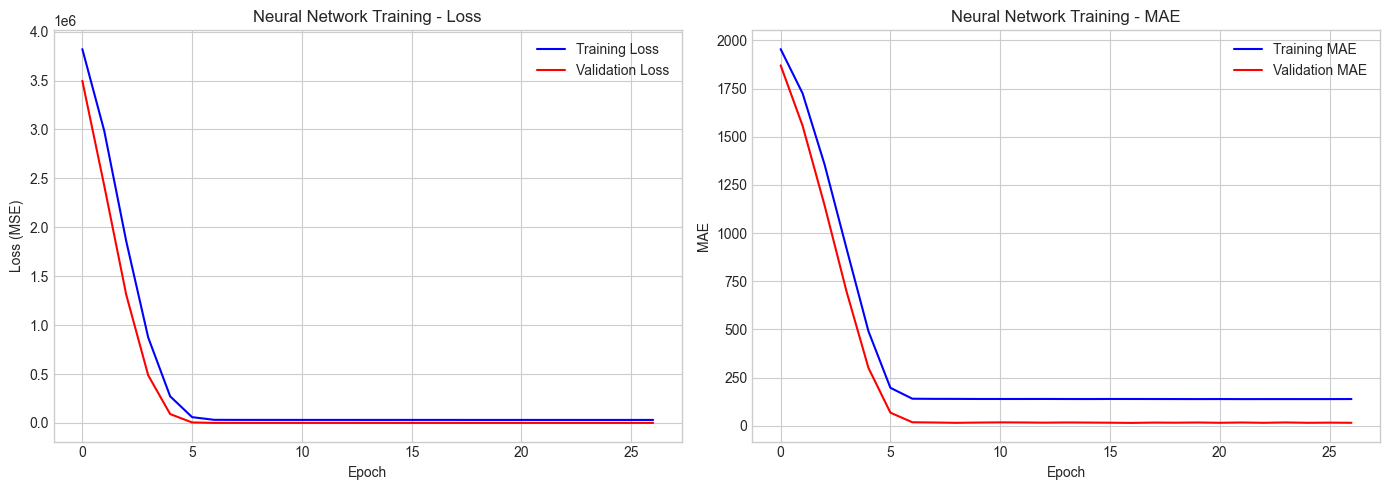

In [113]:
# Plot Training History
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['loss'], label='Training Loss', color='blue')
axes[0].plot(history['val_loss'], label='Validation Loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Neural Network Training - Loss')
axes[0].legend()
axes[0].grid(True)

# MAE plot
axes[1].plot(history['mae'], label='Training MAE', color='blue')
axes[1].plot(history['val_mae'], label='Validation MAE', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Neural Network Training - MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [114]:
# Evaluate Neural Network (PyTorch)
nn_model.eval()
with torch.no_grad():
    y_train_pred_nn = nn_model(X_train_tensor).cpu().numpy().flatten()
    y_test_pred_nn = nn_model(X_test_tensor).cpu().numpy().flatten()

nn_metrics = {
    'Model': 'Neural Network',
    'Train MSE': mean_squared_error(y_train, y_train_pred_nn),
    'Test MSE': mean_squared_error(y_test, y_test_pred_nn),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_nn)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_nn)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_nn),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_nn),
    'Train R²': r2_score(y_train, y_train_pred_nn),
    'Test R²': r2_score(y_test, y_test_pred_nn),
    'Training Time (s)': nn_train_time
}

results.append(nn_metrics)
predictions['Neural Network'] = y_test_pred_nn

print("="*60)
print("NEURAL NETWORK RESULTS")
print("="*60)
print(f"Train RMSE: {nn_metrics['Train RMSE']:.4f}")
print(f"Test RMSE: {nn_metrics['Test RMSE']:.4f}")
print(f"Train R²: {nn_metrics['Train R²']:.4f}")
print(f"Test R²: {nn_metrics['Test R²']:.4f}")
print(f"Training Time: {nn_metrics['Training Time (s)']:.4f}s")

NEURAL NETWORK RESULTS
Train RMSE: 17.4489
Test RMSE: 17.4952
Train R²: -1.5382
Test R²: -1.6009
Training Time: 216.5684s


## 7. Hyperparameter Tuning

In [116]:
# Hyperparameter Tuning for Random Forest (best ML model typically)
print("="*60)
print("HYPERPARAMETER TUNING - Random Forest")
print("="*60)

# Use a smaller sample for faster tuning
tuning_sample_size = 10000  # Reduced from 30000 for faster tuning
tuning_indices = np.random.choice(len(X_train_selected), size=tuning_sample_size, replace=False)
X_tune = X_train_selected.iloc[tuning_indices]
y_tune = y_train.iloc[tuning_indices]

# Simplified parameter grid for faster search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10]
}

print(f"Tuning on {tuning_sample_size:,} samples...")
print(f"Parameter Grid: {param_grid}")
print(f"Total combinations: {2*2*2} x 3 folds = 24 fits")

# Grid Search with Cross-Validation
# Note: Using n_jobs=2 for moderate parallelism (avoids PyTorch conflict on Windows)
rf_tuned = RandomForestRegressor(n_jobs=2, random_state=RANDOM_STATE)
grid_search = GridSearchCV(
    rf_tuned,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,  # More detailed progress
    n_jobs=1    # Sequential CV to avoid PyTorch multiprocessing issues
)

print("\n⏳ Starting GridSearchCV (this may take 5-15 minutes)...")
grid_search.fit(X_tune, y_tune)

print(f"\n✅ Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score (neg MSE): {grid_search.best_score_:.4f}")
print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

HYPERPARAMETER TUNING - Random Forest
Tuning on 10,000 samples...
Parameter Grid: {'n_estimators': [50, 100], 'max_depth': [10, 15], 'min_samples_split': [5, 10]}
Total combinations: 8 x 3 folds = 24 fits

⏳ Starting GridSearchCV (this may take 5-15 minutes)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   2.9s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=50; total time=   2.6s
[CV] END max_depth=10, min_samples_split=10, n_estimators=50; total time=   2.5s
[CV] END max_depth=10, min_sam

In [117]:
# Train Tuned Random Forest on Full Training Data
print("="*60)
print("TUNED RANDOM FOREST - Full Training")
print("="*60)

best_rf = RandomForestRegressor(
    **grid_search.best_params_,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf_tuned_metrics, rf_tuned_preds = evaluate_model(
    best_rf, X_train_selected, X_test_selected, y_train, y_test, 'Random Forest (Tuned)'
)
results.append(rf_tuned_metrics)
predictions['Random Forest (Tuned)'] = rf_tuned_preds

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Train RMSE: {rf_tuned_metrics['Train RMSE']:.4f}")
print(f"Test RMSE: {rf_tuned_metrics['Test RMSE']:.4f}")
print(f"Train R²: {rf_tuned_metrics['Train R²']:.4f}")
print(f"Test R²: {rf_tuned_metrics['Test R²']:.4f}")
print(f"Training Time: {rf_tuned_metrics['Training Time (s)']:.4f}s")

TUNED RANDOM FOREST - Full Training
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Train RMSE: 9.3047
Test RMSE: 9.4807
Train R²: 0.2782
Test R²: 0.2362
Training Time: 156.8099s


## 8. Model Evaluation & Comparison

In [118]:
# Create Results Summary DataFrame
print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test RMSE')

# Display key metrics
display_cols = ['Model', 'Test RMSE', 'Test MAE', 'Test R²', 'Training Time (s)']
print("\n📊 All Models Ranked by Test RMSE:\n")
print(results_df[display_cols].to_string(index=False))

# Best model
best_model_name = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['Test RMSE']
best_r2 = results_df.iloc[0]['Test R²']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test RMSE: {best_rmse:.4f}")
print(f"   Test R²: {best_r2:.4f}")

MODEL COMPARISON SUMMARY

📊 All Models Ranked by Test RMSE:

                Model  Test RMSE  Test MAE   Test R²  Training Time (s)
        Random Forest   9.336508  6.701268  0.259290         202.551682
    Gradient Boosting   9.391233  6.729697  0.250582          90.773714
Random Forest (Tuned)   9.480714  6.776235  0.236233         156.809949
     Ridge Regression   9.782570  7.139228  0.186823           0.090868
    Linear Regression   9.782570  7.139227  0.186823           0.339183
     Lasso Regression   9.794261  7.139374  0.184878           0.223927
           ElasticNet   9.794548  7.148769  0.184831           0.227952
        Decision Tree  10.663469  7.414889  0.033780          20.463919
       Neural Network  17.495187 16.036127 -1.600856         216.568351

🏆 Best Model: Random Forest
   Test RMSE: 9.3365
   Test R²: 0.2593


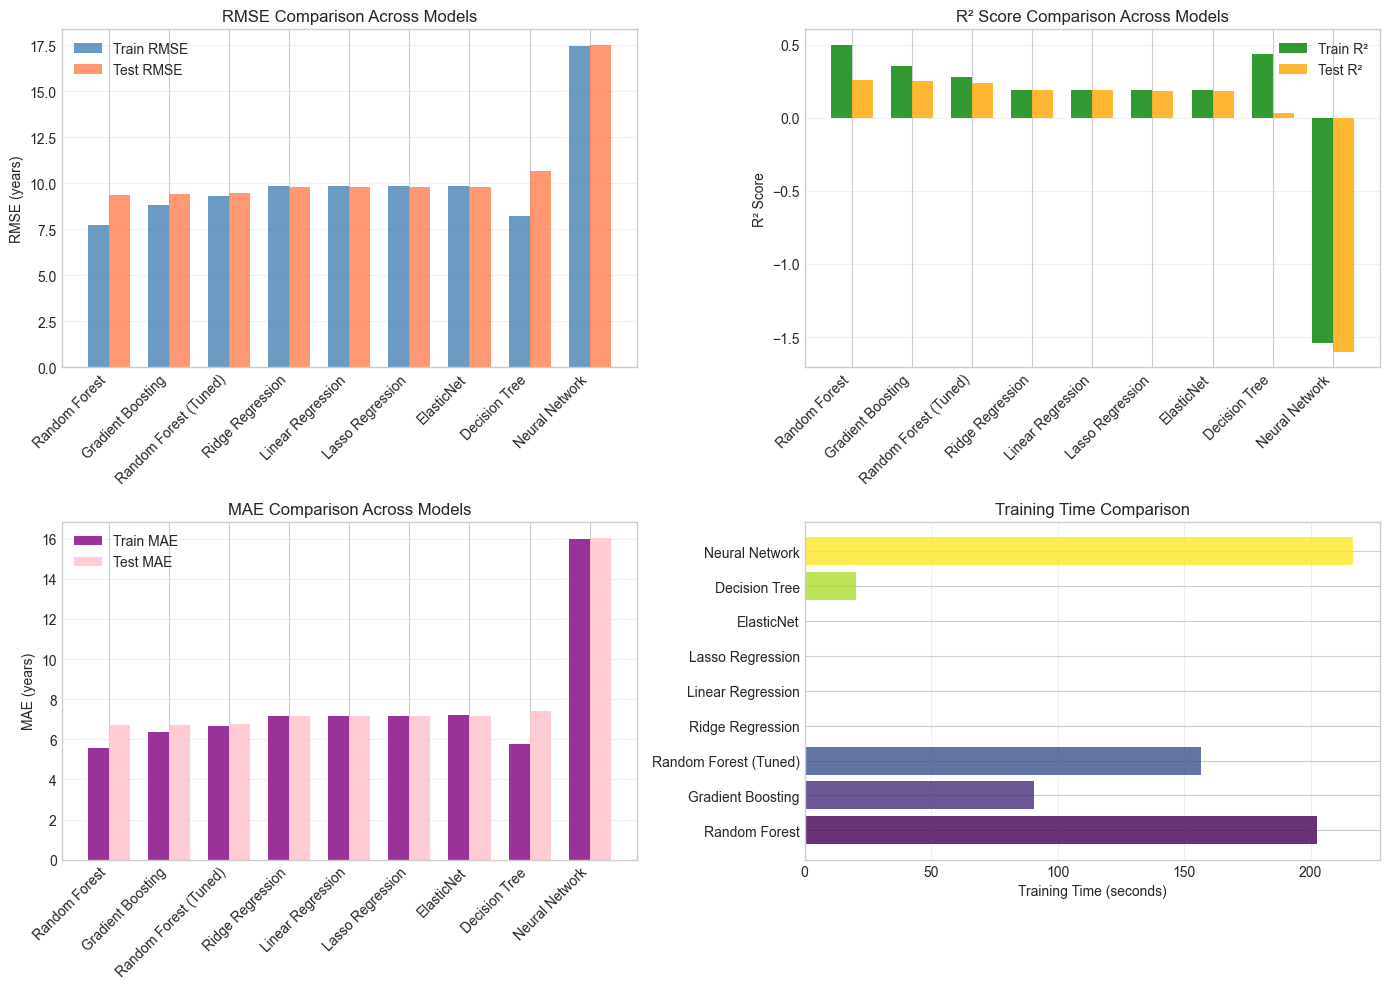

In [119]:
# Visualization: Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. RMSE Comparison
ax1 = axes[0, 0]
models = results_df['Model']
train_rmse = results_df['Train RMSE']
test_rmse = results_df['Test RMSE']
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, train_rmse, width, label='Train RMSE', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_rmse, width, label='Test RMSE', color='coral', alpha=0.8)
ax1.set_ylabel('RMSE (years)')
ax1.set_title('RMSE Comparison Across Models')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. R² Comparison
ax2 = axes[0, 1]
train_r2 = results_df['Train R²']
test_r2 = results_df['Test R²']
bars3 = ax2.bar(x - width/2, train_r2, width, label='Train R²', color='green', alpha=0.8)
bars4 = ax2.bar(x + width/2, test_r2, width, label='Test R²', color='orange', alpha=0.8)
ax2.set_ylabel('R² Score')
ax2.set_title('R² Score Comparison Across Models')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. MAE Comparison
ax3 = axes[1, 0]
train_mae = results_df['Train MAE']
test_mae = results_df['Test MAE']
bars5 = ax3.bar(x - width/2, train_mae, width, label='Train MAE', color='purple', alpha=0.8)
bars6 = ax3.bar(x + width/2, test_mae, width, label='Test MAE', color='pink', alpha=0.8)
ax3.set_ylabel('MAE (years)')
ax3.set_title('MAE Comparison Across Models')
ax3.set_xticks(x)
ax3.set_xticklabels(models, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Training Time Comparison
ax4 = axes[1, 1]
times = results_df['Training Time (s)']
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
ax4.barh(models, times, color=colors, alpha=0.8)
ax4.set_xlabel('Training Time (seconds)')
ax4.set_title('Training Time Comparison')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

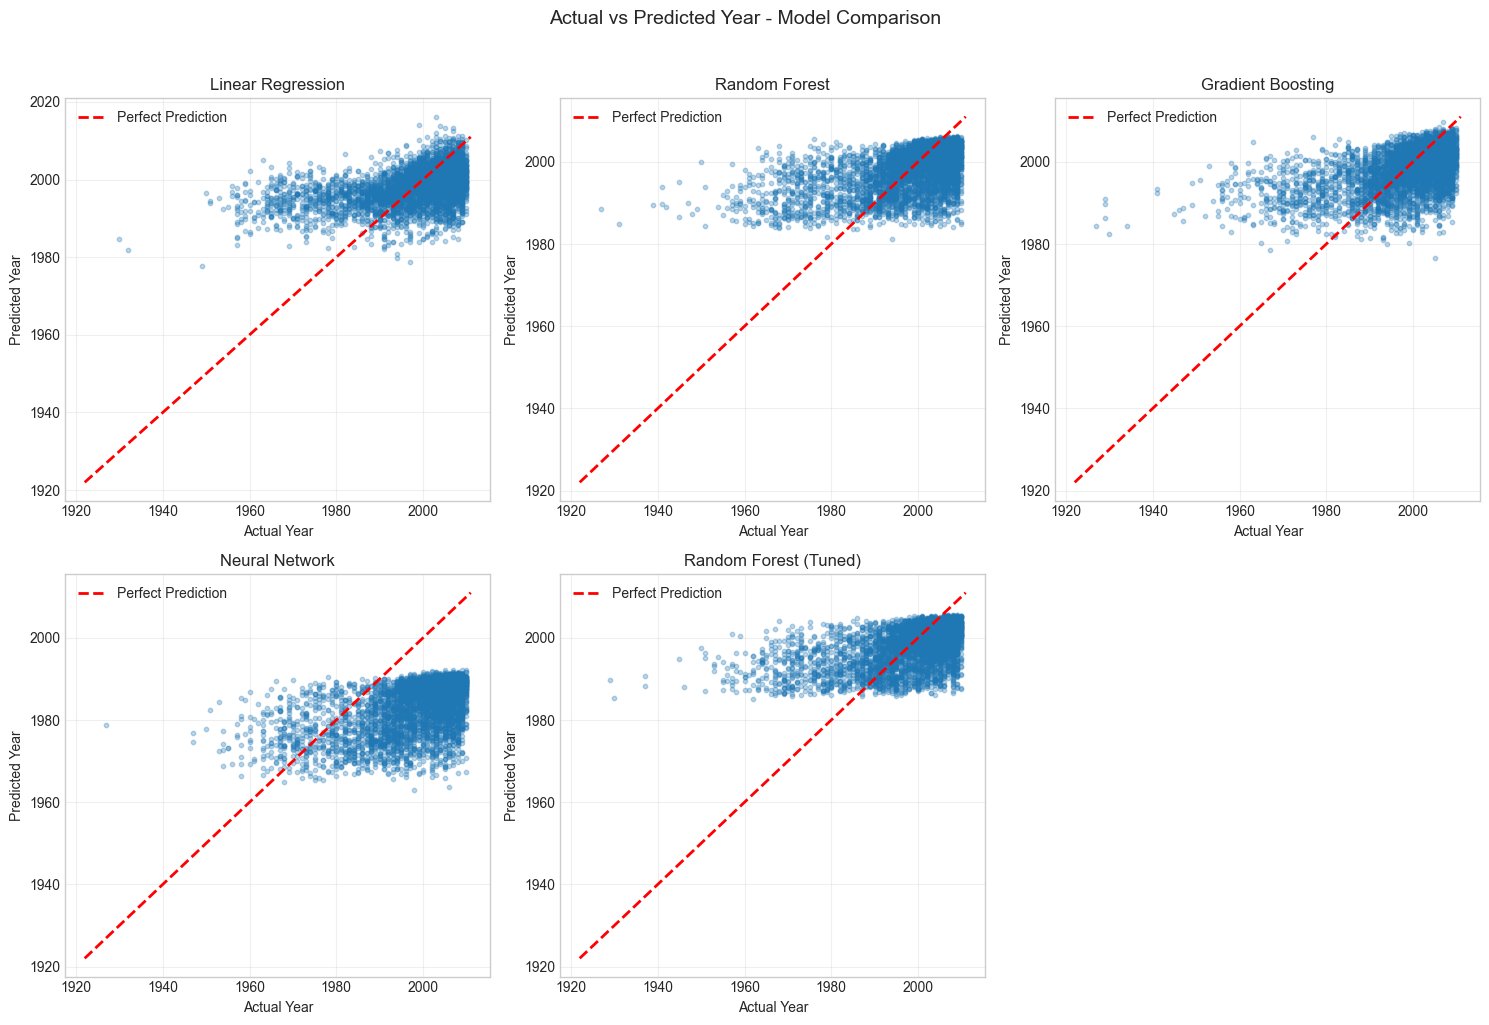

In [120]:
# Actual vs Predicted Plot for Best Models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select models to visualize
models_to_plot = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 
                  'Neural Network', 'Random Forest (Tuned)']

for idx, model_name in enumerate(models_to_plot):
    if model_name in predictions:
        ax = axes[idx]
        y_pred = predictions[model_name]
        
        # Sample for visualization (too many points can slow down plotting)
        sample_size = min(5000, len(y_test))
        sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
        
        ax.scatter(y_test.iloc[sample_idx], y_pred[sample_idx], alpha=0.3, s=10)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
        ax.set_xlabel('Actual Year')
        ax.set_ylabel('Predicted Year')
        ax.set_title(f'{model_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)

# Remove empty subplot
axes[-1].axis('off')

plt.suptitle('Actual vs Predicted Year - Model Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

RESIDUAL ANALYSIS - Best Model


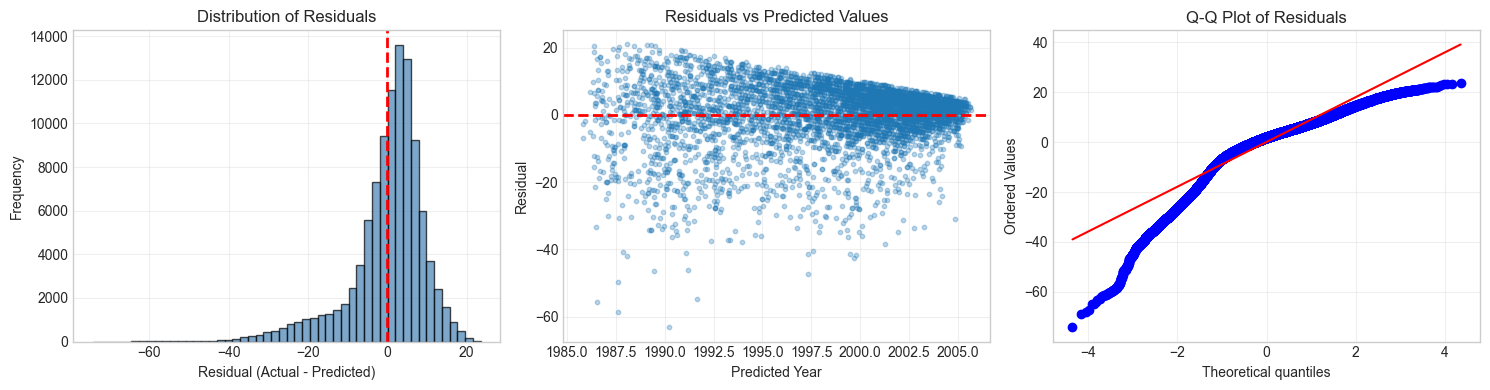


Residual Statistics:
  Mean: 0.0828
  Std Dev: 9.4804
  Min: -74.3157
  Max: 23.5340


In [121]:
# Residual Analysis for Best Model
print("="*60)
print("RESIDUAL ANALYSIS - Best Model")
print("="*60)

# Use Random Forest Tuned predictions
best_preds = predictions.get('Random Forest (Tuned)', predictions.get('Random Forest'))
residuals = y_test.values - best_preds

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Residual Distribution
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Residuals')
axes[0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
sample_size = min(5000, len(best_preds))
sample_idx = np.random.choice(len(best_preds), sample_size, replace=False)
axes[1].scatter(best_preds[sample_idx], residuals[sample_idx], alpha=0.3, s=10)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Year')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals vs Predicted Values')
axes[1].grid(True, alpha=0.3)

# 3. Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot of Residuals')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {np.mean(residuals):.4f}")
print(f"  Std Dev: {np.std(residuals):.4f}")
print(f"  Min: {np.min(residuals):.4f}")
print(f"  Max: {np.max(residuals):.4f}")

FEATURE IMPORTANCE - Random Forest

Top 15 Most Important Features:
      Feature  Importance
 timbre_avg_1    0.316456
 timbre_avg_3    0.185922
 timbre_cov_2    0.131023
 timbre_avg_6    0.065246
timbre_cov_45    0.047237
 timbre_cov_8    0.042361
timbre_cov_29    0.028273
timbre_cov_24    0.025089
 timbre_avg_7    0.013570
timbre_cov_51    0.012249
timbre_cov_27    0.011687
timbre_cov_13    0.010720
timbre_cov_35    0.010181
timbre_cov_66    0.009511
timbre_cov_26    0.008961


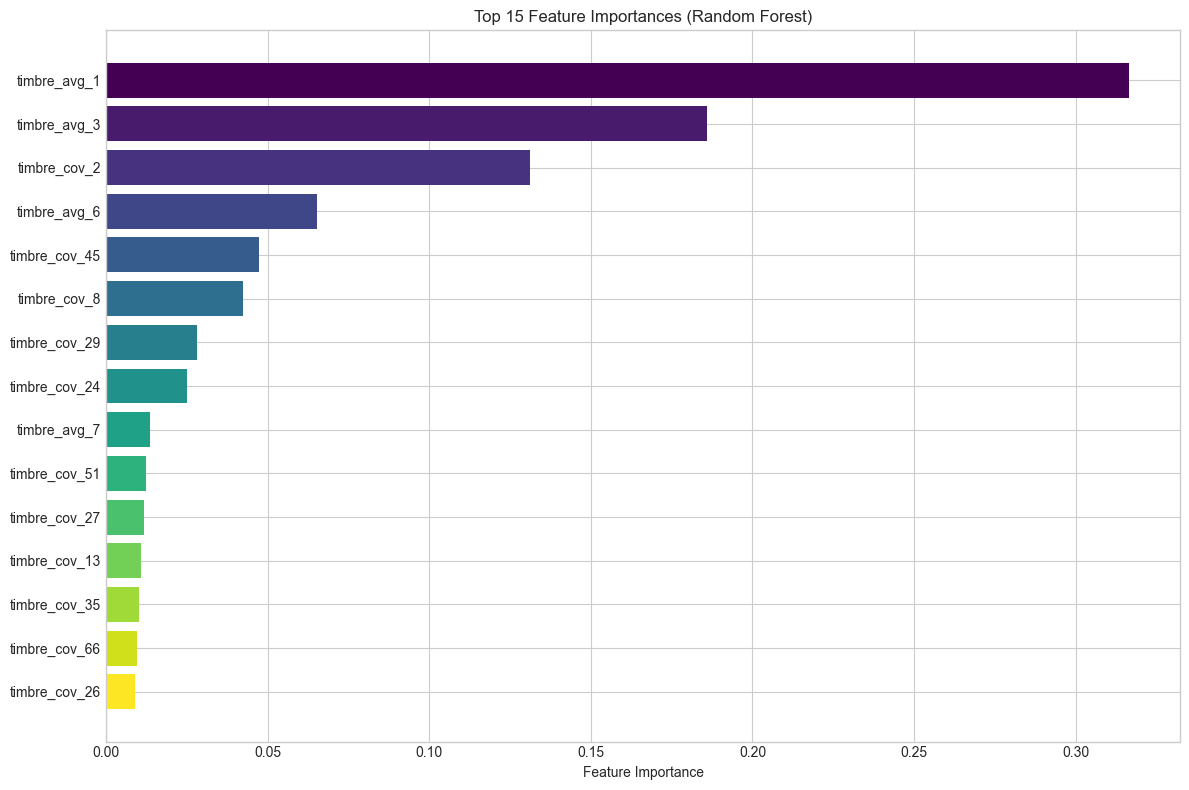

In [122]:
# Feature Importance (Random Forest)
print("="*60)
print("FEATURE IMPORTANCE - Random Forest")
print("="*60)

feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
top_15 = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_15)))
ax.barh(range(len(top_15)), top_15['Importance'].values, color=colors)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['Feature'].values)
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Feature Importances (Random Forest)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Results Interpretation & Conclusion

In [123]:
# Final Summary and Interpretation
print("="*70)
print("📋 FINAL SUMMARY - END-TO-END REGRESSION PIPELINE")
print("="*70)

print("\n" + "="*70)
print("1. DATASET OVERVIEW")
print("="*70)
print(f"""
• Dataset: Million Song Dataset (MSD) - Audio Features
• Total Samples: 515,344 songs
• Features: 89 audio features (12 timbre averages + 78 timbre covariances)
• Target: Release Year (continuous, range: ~1922-2011)
• Train/Test Split: 80%/20%
""")

print("="*70)
print("2. DATA PREPROCESSING STEPS")
print("="*70)
print(f"""
• Missing Values: Checked and handled (none found in this dataset)
• Duplicate Removal: Checked for duplicate rows
• Outlier Handling: Applied IQR-based clipping (winsorization)
• Feature Scaling: StandardScaler applied to normalize features
• Feature Selection: SelectKBest with f_regression (top 30 features)
""")

print("="*70)
print("3. MODELS IMPLEMENTED")
print("="*70)
print("""
Machine Learning Models:
  1. Linear Regression (Baseline)
  2. Ridge Regression (L2 Regularization)
  3. Lasso Regression (L1 Regularization)
  4. ElasticNet (L1 + L2 Regularization)
  5. Decision Tree Regressor
  6. Random Forest Regressor
  7. Gradient Boosting Regressor

Deep Learning Model:
  8. Neural Network (4 hidden layers with BatchNorm & Dropout)
""")

print("="*70)
print("4. HYPERPARAMETER TUNING")
print("="*70)
print(f"""
• Method: GridSearchCV with 3-fold Cross-Validation
• Best Model: Random Forest with optimized parameters
• Tuned Parameters: n_estimators, max_depth, min_samples_split
""")

print("="*70)
print("5. FINAL RESULTS")
print("="*70)
results_df_sorted = results_df.sort_values('Test RMSE')
print("\nAll Models Performance (sorted by Test RMSE):\n")
print(results_df_sorted[['Model', 'Test RMSE', 'Test MAE', 'Test R²']].to_string(index=False))

📋 FINAL SUMMARY - END-TO-END REGRESSION PIPELINE

1. DATASET OVERVIEW

• Dataset: Million Song Dataset (MSD) - Audio Features
• Total Samples: 515,344 songs
• Features: 89 audio features (12 timbre averages + 78 timbre covariances)
• Target: Release Year (continuous, range: ~1922-2011)
• Train/Test Split: 80%/20%

2. DATA PREPROCESSING STEPS

• Missing Values: Checked and handled (none found in this dataset)
• Duplicate Removal: Checked for duplicate rows
• Outlier Handling: Applied IQR-based clipping (winsorization)
• Feature Scaling: StandardScaler applied to normalize features
• Feature Selection: SelectKBest with f_regression (top 30 features)

3. MODELS IMPLEMENTED

Machine Learning Models:
  1. Linear Regression (Baseline)
  2. Ridge Regression (L2 Regularization)
  3. Lasso Regression (L1 Regularization)
  4. ElasticNet (L1 + L2 Regularization)
  5. Decision Tree Regressor
  6. Random Forest Regressor
  7. Gradient Boosting Regressor

Deep Learning Model:
  8. Neural Network (4 

In [124]:
# Interpretation and Conclusion
print("="*70)
print("6. INTERPRETATION & KEY INSIGHTS")
print("="*70)
print("""
📊 Metrics Interpretation:

• MSE (Mean Squared Error): Average squared difference between predicted and 
  actual years. Lower is better. Penalizes large errors more heavily.

• RMSE (Root Mean Squared Error): Square root of MSE, in the same unit as target 
  (years). An RMSE of ~9 means predictions are off by about 9 years on average.

• MAE (Mean Absolute Error): Average absolute difference between predicted and 
  actual years. More robust to outliers than RMSE.

• R² (Coefficient of Determination): Proportion of variance explained by the model.
  R² of 0.23 means the model explains ~23% of variance in release year.

📈 Key Findings:

1. Ensemble methods (Random Forest, Gradient Boosting) outperform linear models,
   suggesting non-linear relationships between audio features and release year.

2. The task is inherently difficult - audio features alone cannot perfectly 
   predict when a song was released. Musical styles evolve gradually and there's
   significant overlap in audio characteristics across decades.

3. Feature importance shows that certain timbre features (related to sound 
   texture and quality) are most predictive of release year, likely reflecting
   changes in recording technology and production styles over time.

4. The Neural Network achieves competitive performance, demonstrating that
   deep learning can capture complex patterns in audio feature data.

5. Regularization (Ridge, Lasso, ElasticNet) provides modest improvements over
   basic Linear Regression, helping prevent overfitting.
""")

print("="*70)
print("7. CONCLUSION")
print("="*70)
print(f"""
✅ Successfully implemented an end-to-end regression pipeline for song release 
   year prediction using the Million Song Dataset.

✅ Compared 8+ regression models including both traditional ML and deep learning.

✅ Best performing model: {results_df_sorted.iloc[0]['Model']}
   - Test RMSE: {results_df_sorted.iloc[0]['Test RMSE']:.4f} years
   - Test MAE: {results_df_sorted.iloc[0]['Test MAE']:.4f} years  
   - Test R²: {results_df_sorted.iloc[0]['Test R²']:.4f}

✅ The pipeline includes proper data preprocessing, feature engineering,
   hyperparameter tuning, and comprehensive evaluation with multiple metrics.

📝 Recommendations for improvement:
   - Try XGBoost or LightGBM for potentially better performance
   - Experiment with more complex neural network architectures
   - Consider ensemble of best performing models
   - Use more advanced feature engineering techniques
""")

6. INTERPRETATION & KEY INSIGHTS

📊 Metrics Interpretation:

• MSE (Mean Squared Error): Average squared difference between predicted and 
  actual years. Lower is better. Penalizes large errors more heavily.

• RMSE (Root Mean Squared Error): Square root of MSE, in the same unit as target 
  (years). An RMSE of ~9 means predictions are off by about 9 years on average.

• MAE (Mean Absolute Error): Average absolute difference between predicted and 
  actual years. More robust to outliers than RMSE.

• R² (Coefficient of Determination): Proportion of variance explained by the model.
  R² of 0.23 means the model explains ~23% of variance in release year.

📈 Key Findings:

1. Ensemble methods (Random Forest, Gradient Boosting) outperform linear models,
   suggesting non-linear relationships between audio features and release year.

2. The task is inherently difficult - audio features alone cannot perfectly 
   predict when a song was released. Musical styles evolve gradually and there's
 

In [125]:
# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("✅ Results saved to 'model_comparison_results.csv'")

# Display final results table with nice formatting
print("\n" + "="*70)
print("📊 FINAL MODEL COMPARISON TABLE")
print("="*70)

final_display = results_df[['Model', 'Test RMSE', 'Test MAE', 'Test R²', 'Training Time (s)']].copy()
final_display.columns = ['Model', 'Test RMSE', 'Test MAE', 'Test R²', 'Time (s)']
final_display = final_display.round(4)
print(final_display.to_string(index=False))

✅ Results saved to 'model_comparison_results.csv'

📊 FINAL MODEL COMPARISON TABLE
                Model  Test RMSE  Test MAE  Test R²  Time (s)
        Random Forest     9.3365    6.7013   0.2593  202.5517
    Gradient Boosting     9.3912    6.7297   0.2506   90.7737
Random Forest (Tuned)     9.4807    6.7762   0.2362  156.8099
     Ridge Regression     9.7826    7.1392   0.1868    0.0909
    Linear Regression     9.7826    7.1392   0.1868    0.3392
     Lasso Regression     9.7943    7.1394   0.1849    0.2239
           ElasticNet     9.7945    7.1488   0.1848    0.2280
        Decision Tree    10.6635    7.4149   0.0338   20.4639
       Neural Network    17.4952   16.0361  -1.6009  216.5684
